In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from IPython.display import clear_output

''' this is an adapted version of ricky's ode_demo.py '''


" this is an adapted version of ricky's ode_demo.py "

In [ ]:
from cosmoNODE.loaders import Anode as A
device = torch.device('cpu')

In [ ]:
from cosmoNODE.loaders import LC

In [93]:
adjoint = False

viz = True
viz_at_end = True
data_size = 350
batch_time = 25
batch_size = 175

test_freq = 5

In [3]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [4]:
a = A()
dataloader = DataLoader(a)
item = a[0]
lc = item[0]
obj_class = item[1]
lc = lc.squeeze()

In [30]:
mjds = lc[:, 0]
fluxes = lc[:, 1]
flux_y0 = fluxes[0].reshape(1, -1) # torch.Size([1, 1])
true_f = fluxes.reshape(-1, 1, 1)

tensor([[-544.8103]])
tensor([[[ -544.8103]],

        [[ -816.4343]],

        [[ -471.3855]],

        [[ -388.9850]],

        [[ -681.8589]],

        [[-1061.4570]],

        [[ -524.9546]],

        [[ -393.4802]],

        [[ -355.8868]],

        [[ -548.0135]],

        [[ -815.1886]],

        [[ -475.5161]],

        [[ -405.6638]],

        [[ -421.1991]],

        [[ -554.9032]],

        [[ -820.0428]],

        [[ -477.0047]],

        [[ -400.2704]],

        [[ -415.2869]],

        [[ -630.5237]],

        [[ -921.0025]],

        [[ -518.5340]],

        [[ -422.1845]],

        [[ -422.8151]],

        [[ -280.0395]],

        [[ -449.0956]],

        [[ -316.7049]],

        [[ -332.8854]],

        [[ -365.0758]],

        [[  391.3992]],

        [[   35.5118]],

        [[  330.6239]],

        [[  360.3979]],

        [[  369.4397]],

        [[  168.7399]],

        [[  129.5419]],

        [[   30.1207]],

        [[  -60.9423]],

        [[ -128.9203]],

   

In [6]:
true_y0 = torch.tensor([[2., 0.]]) # torch.Size([1, 2])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [94]:
def flux_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_f[s]  # (M, D)
    batch_t = mjds[:batch_time]  # (T)
    batch_y = torch.stack([true_f[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [95]:
batch_1 = flux_batch()
batch_2 = flux_batch()

In [96]:
by0_f, bt_f, by_f = flux_batch()
print(f'by0_f.shape : {by0_f.shape}, bt_f.shape: {bt_f.shape}, by_f.shape: {by_f.shape}')

by0_f.shape : torch.Size([175, 1, 1]), bt_f.shape: torch.Size([25]), by_f.shape: torch.Size([25, 175, 1, 1])


In [9]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [10]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [11]:
by0_f, bt_f, by_f = flux_batch()
# by0, bt, by = get_batch()

In [12]:
# print(f'by0.shape : {by0.shape}, bt.shape: {bt.shape}, by.shape: {by.shape}')
print(f'by0.shape : {by0_f.shape}, bt.shape: {bt_f.shape}, by.shape: {by_f.shape}')

by0.shape : torch.Size([50, 1, 1]), bt.shape: torch.Size([25]), by.shape: torch.Size([25, 50, 1, 1])


In [13]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

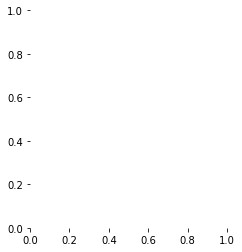

In [15]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
# ax_phase = fig.add_subplot(132, frameon=False)
# ax_vecfield = fig.add_subplot(133, frameon=False)
plt.show(block=False)

In [16]:
def visualize(true_y, pred_y, odefunc, itr):
    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('mjd')
    ax_traj.set_ylabel('flux')
    ax_traj.plot(mjds.numpy(), true_y.numpy()[:, 0, 0])
    ax_traj.plot(mjds.numpy(), pred_y.numpy()[:, 0, 0], '--')
    ax_traj.set_xlim(mjds.min(), mjds.max())
#     ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

#     ax_phase.cla()
#     ax_phase.set_title('Phase Portrait')
#     ax_phase.set_xlabel('x')
#     ax_phase.set_ylabel('y')
#     ax_phase.plot(true_y.numpy()[:, 0], true_y.numpy()[:, 1], 'g-')
#     ax_phase.plot(pred_y.numpy()[:, 0], pred_y.numpy()[:, 1], 'b--')
#     ax_phase.set_xlim(0, )
#     ax_phase.set_ylim(-2, 2)

#     ax_vecfield.cla()
#     ax_vecfield.set_title('Learned Vector Field')
#     ax_vecfield.set_xlabel('x')
#     ax_vecfield.set_ylabel('mjd')

#     y, x = np.mgrid[-2:2:21j, -2:2:21j]
#     dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
#     mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
#     dydt = (dydt / mag)
#     dydt = dydt.reshape(21, 21, 2)

#     ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
#     ax_vecfield.set_xlim(-2, 2)
#     ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
#     plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    plt.pause(0.001)


In [89]:
epochs = 5
niters = 100
odefunc = ODEFunc()
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-1)
ii = 0
losses = []
# itr = 1

Iter 0060 | Total Loss 228201.546875


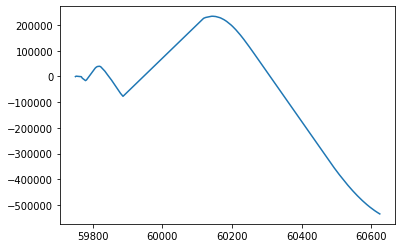

61
62
63
64


KeyboardInterrupt: 

In [97]:
for epoch in range(1, epochs+1):    
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        by0_f, bt_f, by_f = flux_batch()
        pred_f = odeint(odefunc, by0_f, bt_f, rtol=10, atol=5)
        loss = torch.mean(torch.abs(pred_f - by_f))
        loss.backward()
        optimizer.step()
#         print(itr)
        if itr % test_freq == 0:
            with torch.no_grad():
                clear_output()
                pred_f = odeint(odefunc, flux_y0, mjds, rtol=10, atol=5)
                loss = torch.mean(torch.abs(pred_f - true_f))
                losses.append(loss)
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                plt.plot(mjds.tolist(), pred_f.flatten().tolist())
                plt.show()
                ii += 1    

In [ ]:
# print(losses)

pred_f = odeint(odefunc, flux_y0, mjds)
# visualize(true_f, pred_f.detach(), odefunc, itr)




In [ ]:
# without batching
# true_f all of the fluxes

flat_f = true_f.flatten()
plt.plot(mjds.tolist(), flat_f.tolist())

In [88]:
# true_f.numpy()[:, 0, 1]
pred_f.detach().numpy()[:, 0, 0]
# , t.numpy(), true_y.numpy()[:, 0, 1]

array([[-113.58843 ],
       [-113.55888 ],
       [-113.52935 ],
       [-113.49985 ],
       [-105.703514],
       [-105.672455],
       [-105.64139 ],
       [-105.594795],
       [-105.5482  ],
       [ -47.674652]], dtype=float32)

In [101]:
from cosmoNODE.loaders import LC

In [103]:
lc = LC() # light curve but treating different passbands as distinct lightcurves

,object_id,mjd,passband,flux,flux_err,detected
54,615,59819.1532,0,6.878784,3.633152,0
55,615,59820.1047,0,39.364853,3.775619,1
56,615,59821.1026,0,-10.422381,4.172683,0
57,615,59822.1105,0,-65.485130,4.362876,1
58,615,59823.1505,0,-113.349159,4.069051,1
74,615,59851.1114,0,-68.502457,3.338555,1
105,615,59874.0599,0,-97.353195,3.133990,1
106,615,59875.0311,0,-97.523880,2.963075,1
107,615,59876.0231,0,-108.672577,3.449714,1
108,615,59877.0238,0,-116.913223,3.097836,1


In [134]:
def ode_batch(time_sols, flux_sols):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=True))
#     print(s)
    batch_y0 = flux_sols[s]  # (M, D)
    batch_t = time_sols[:batch_time]  # (T)
    batch_y = torch.stack([flux_sols[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [139]:
curve = lc[0][['mjd', 'flux']]
times = torch.tensor(curve['mjd'].values.tolist())


flux_list = torch.tensor(curve['flux'].values.tolist())
flux_0 = flux_list[0].reshape(1, -1) # torch.Size([1, 1])
fluxes = flux_list.reshape(-1, 1, 1)

data_size = len(fluxes) - 1
batch_time = data_size//10
batch_size = data_size

batch = ode_batch(times, fluxes)
batch[0].shape

torch.Size([62, 1, 1])

In [148]:
epochs = 5
niters = 100
odefunc = ODEFunc()
optimizer = optim.RMSprop(odefunc.parameters(), lr=1e-3)
ii = 0
losses = []
# itr = 1

Iter 0005 | Total Loss 542.536194


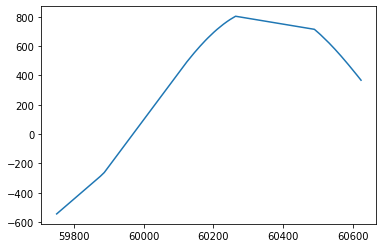

Iter 0010 | Total Loss 514.626343


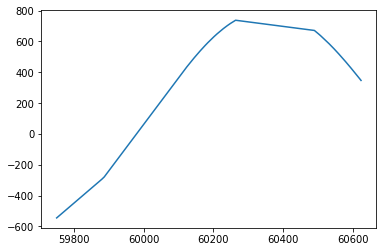

Iter 0015 | Total Loss 616.347290


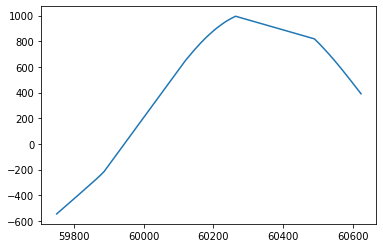

Iter 0020 | Total Loss 649.204468


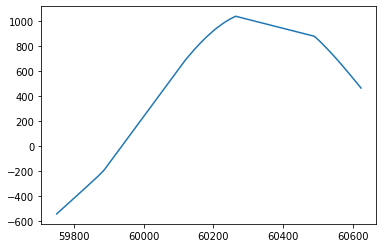

Iter 0025 | Total Loss 762.940186


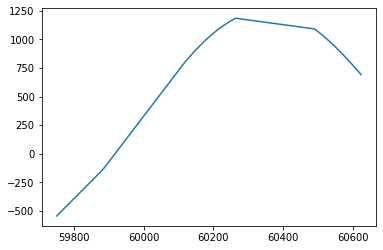

Iter 0030 | Total Loss 759.903931


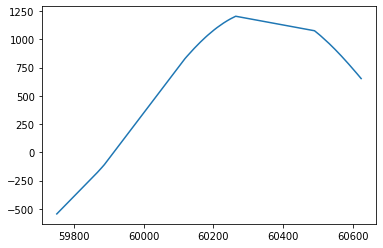

Iter 0035 | Total Loss 652.169312


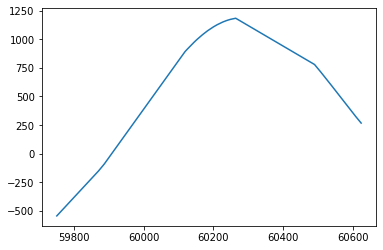

Iter 0040 | Total Loss 605.492126


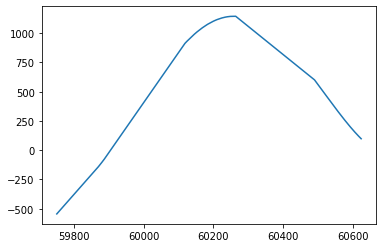

Iter 0045 | Total Loss 613.689331


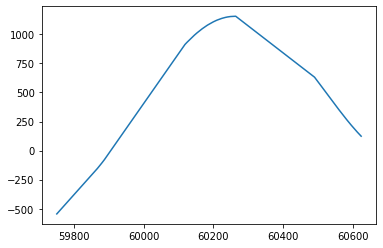

Iter 0050 | Total Loss 594.036987


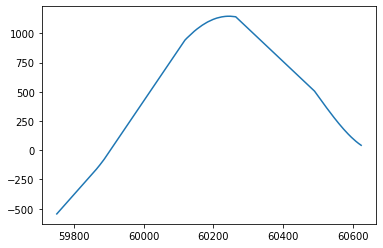

Iter 0055 | Total Loss 529.341248


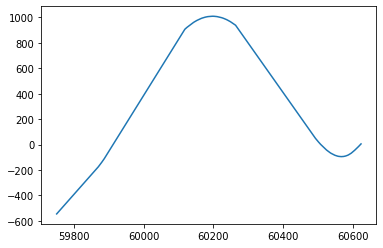

Iter 0060 | Total Loss 511.757202


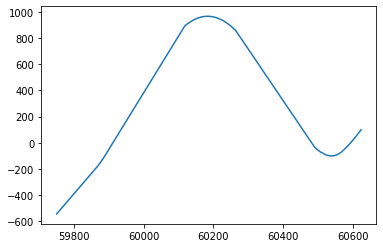

Iter 0065 | Total Loss 518.299072


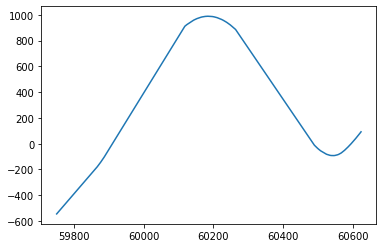

Iter 0070 | Total Loss 550.410889


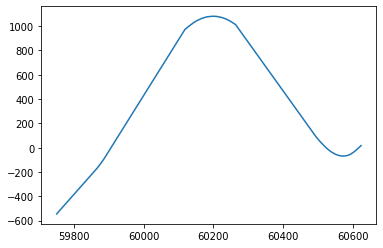

Iter 0075 | Total Loss 530.353943


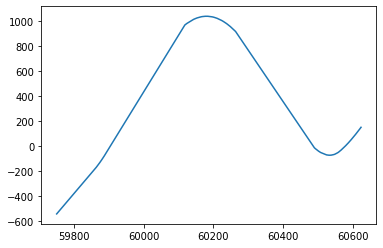

Iter 0080 | Total Loss 497.033234


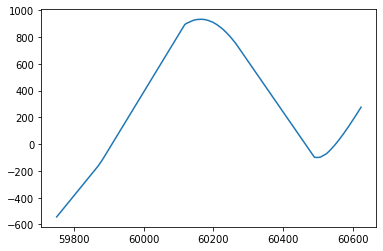

Iter 0085 | Total Loss 494.475616


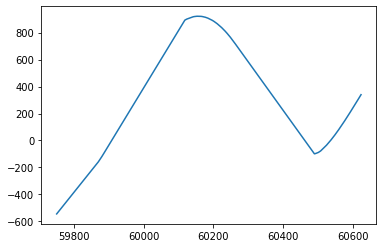

Iter 0090 | Total Loss 529.379456


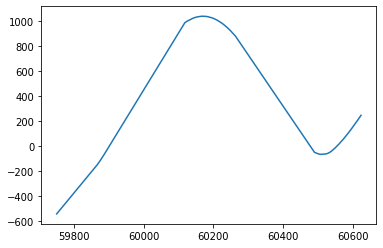

Iter 0095 | Total Loss 523.058228


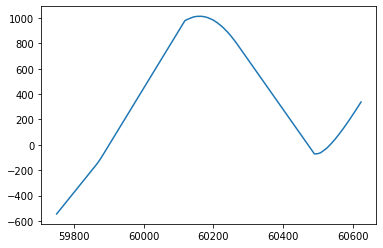

Iter 0100 | Total Loss 509.247833


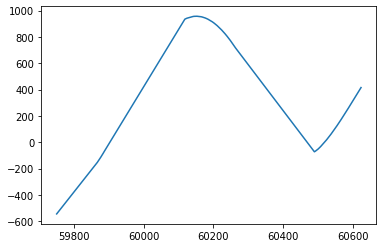

Iter 0005 | Total Loss 538.502258


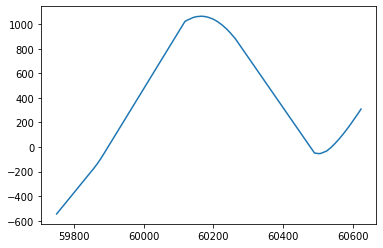

Iter 0010 | Total Loss 524.234985


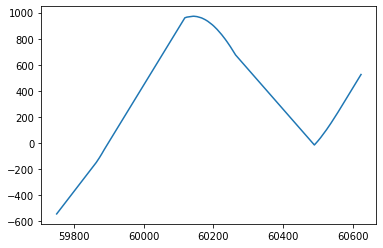

Iter 0015 | Total Loss 530.389832


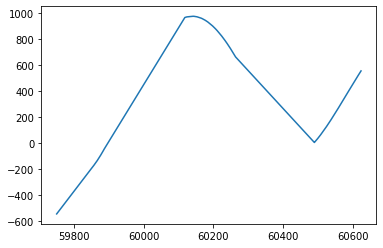

Iter 0020 | Total Loss 539.235107


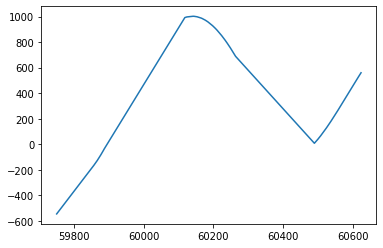

Iter 0025 | Total Loss 540.364990


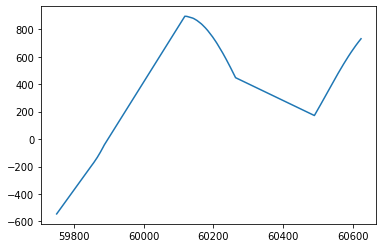

Iter 0030 | Total Loss 549.323303


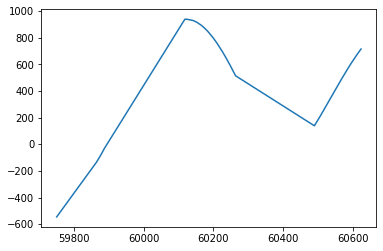

Iter 0035 | Total Loss 549.796143


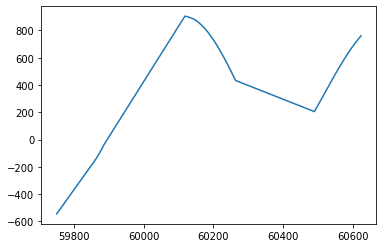

Iter 0040 | Total Loss 563.691467


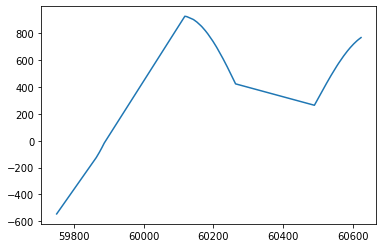

Iter 0045 | Total Loss 558.171936


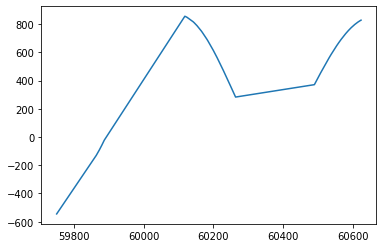

Iter 0050 | Total Loss 564.398010


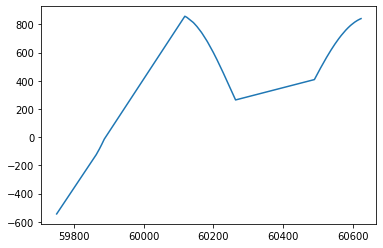

Iter 0055 | Total Loss 420.340729


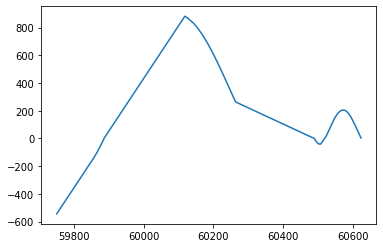

Iter 0060 | Total Loss 358.172729


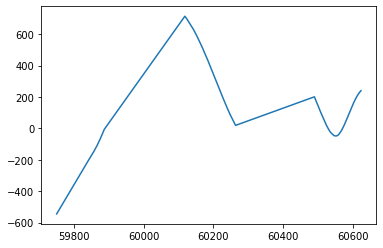

Iter 0065 | Total Loss 528.409363


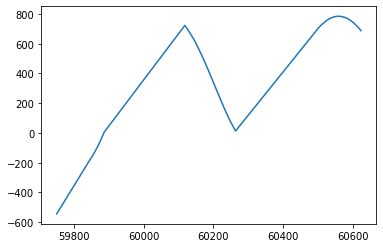

Iter 0070 | Total Loss 340.078156


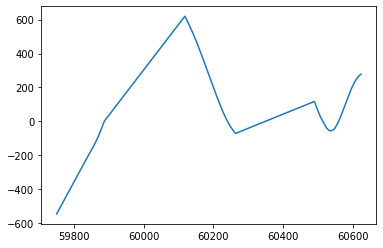

Iter 0075 | Total Loss 334.809570


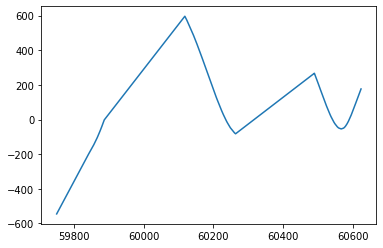

Iter 0080 | Total Loss 334.404419


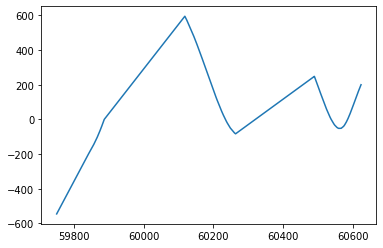

Iter 0085 | Total Loss 339.589142


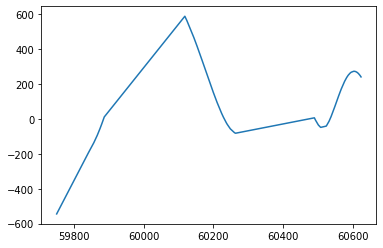

Iter 0090 | Total Loss 324.048126


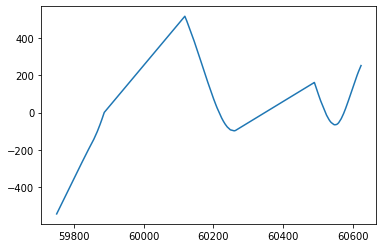

Iter 0095 | Total Loss 360.106873


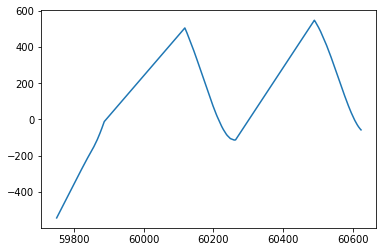

Iter 0100 | Total Loss 538.050171


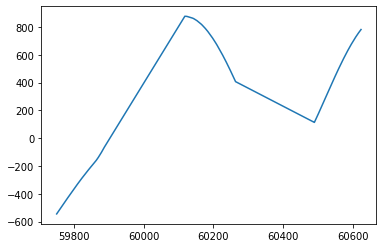

Iter 0005 | Total Loss 336.202850


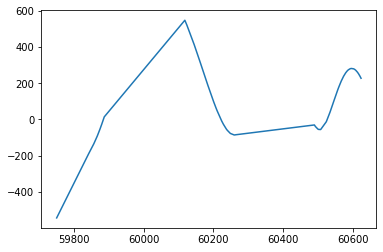

Iter 0010 | Total Loss 324.952301


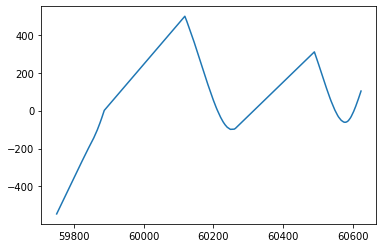

Iter 0015 | Total Loss 335.825562


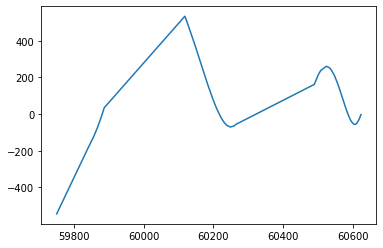

Iter 0020 | Total Loss 325.966919


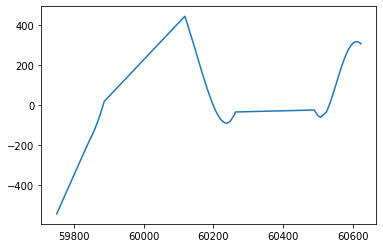

Iter 0025 | Total Loss 336.738525


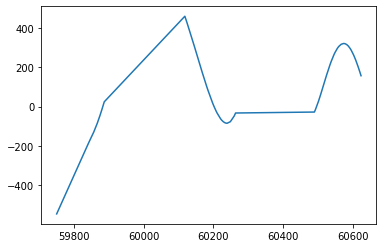

Iter 0030 | Total Loss 314.773773


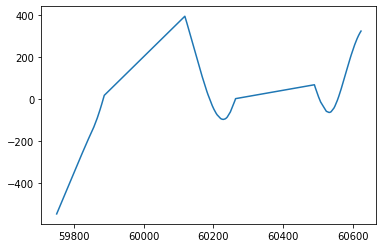

Iter 0035 | Total Loss 333.330048


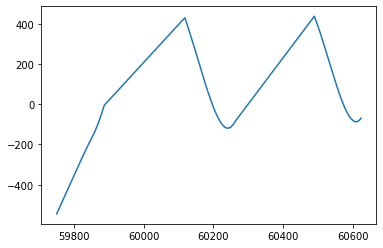

Iter 0040 | Total Loss 312.415314


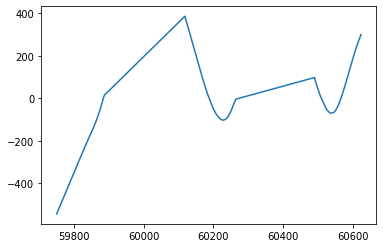

Iter 0045 | Total Loss 331.146759


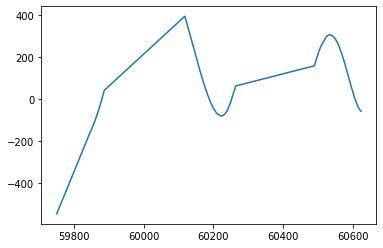

Iter 0050 | Total Loss 316.483978


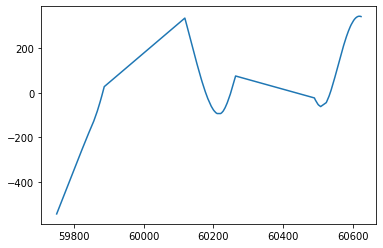

Iter 0055 | Total Loss 326.767120


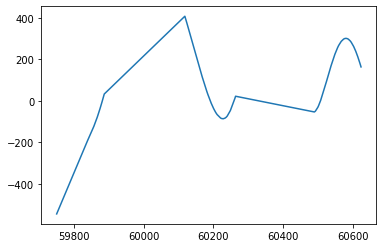

Iter 0060 | Total Loss 329.914215


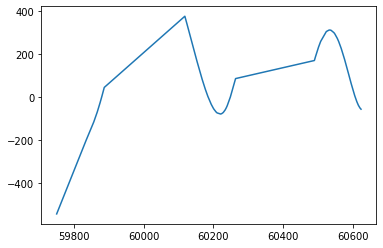

Iter 0065 | Total Loss 314.008545


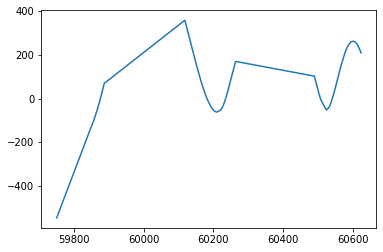

Iter 0070 | Total Loss 312.830353


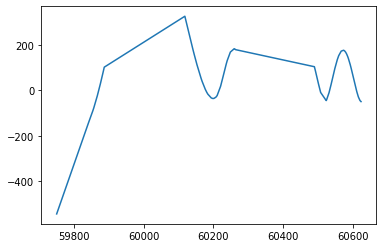

Iter 0075 | Total Loss 300.985168


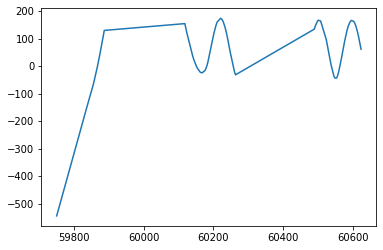

Iter 0080 | Total Loss 310.402008


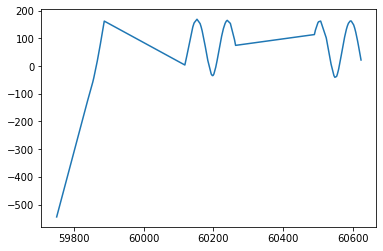

Iter 0085 | Total Loss 314.717316


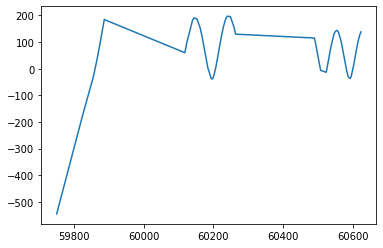

Iter 0090 | Total Loss 300.424255


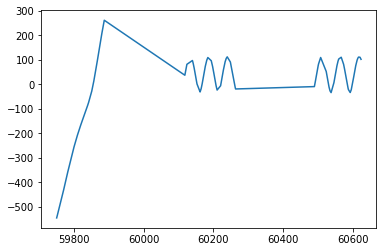

Iter 0095 | Total Loss 318.071655


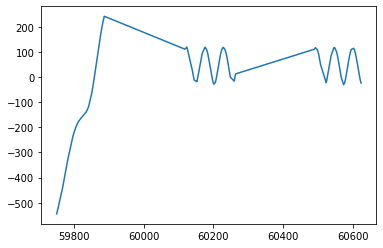

Iter 0100 | Total Loss 304.835327


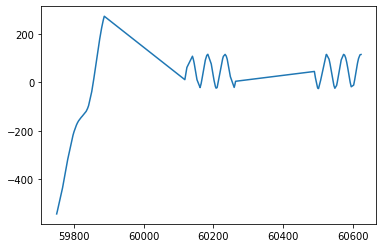

Iter 0005 | Total Loss 313.414703


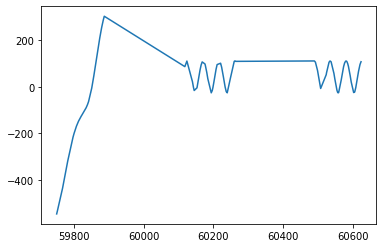

Iter 0010 | Total Loss 406.334167


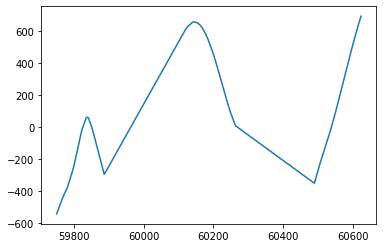

Iter 0015 | Total Loss 527.359924


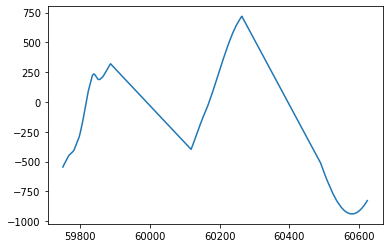

Iter 0020 | Total Loss 549.847168


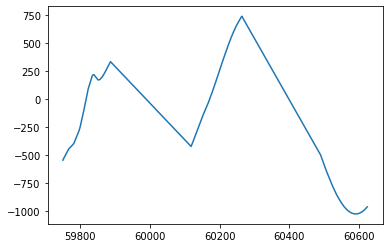

Iter 0025 | Total Loss 299.912018


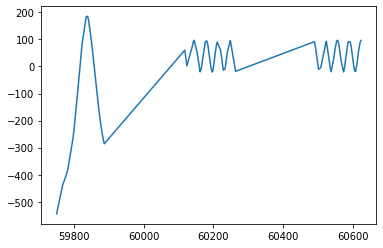

Iter 0030 | Total Loss 457.987213


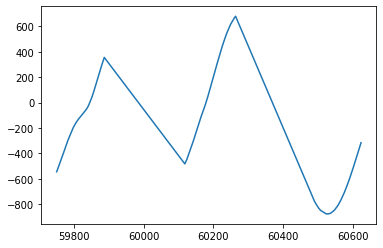

Iter 0035 | Total Loss 537.112732


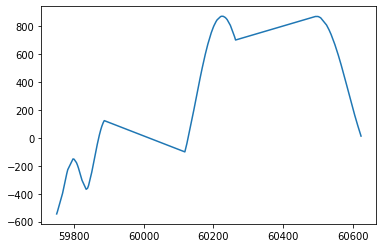

Iter 0040 | Total Loss 555.410095


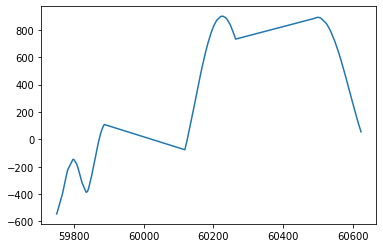

Iter 0045 | Total Loss 475.692749


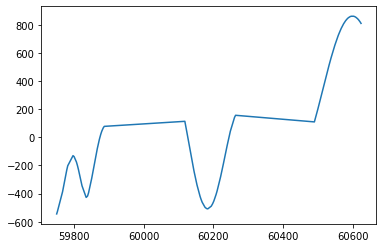

Iter 0050 | Total Loss 466.933472


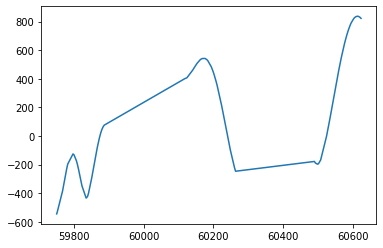

Iter 0055 | Total Loss 513.925171


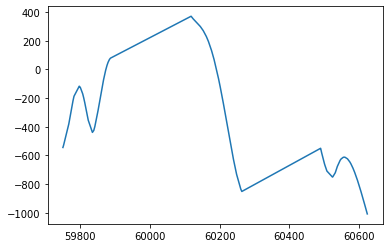

Iter 0060 | Total Loss 481.022369


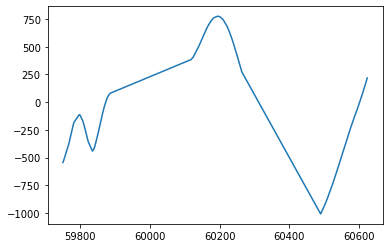

Iter 0065 | Total Loss 499.138153


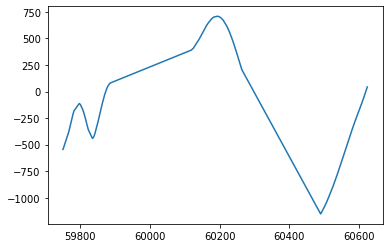

Iter 0070 | Total Loss 519.178223


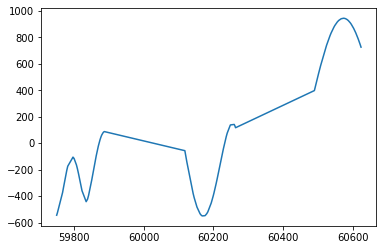

Iter 0075 | Total Loss 519.935547


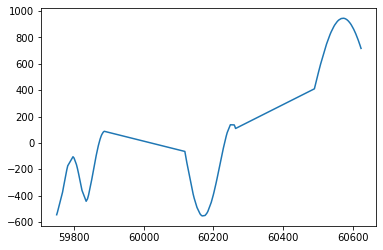

Iter 0080 | Total Loss 500.816315


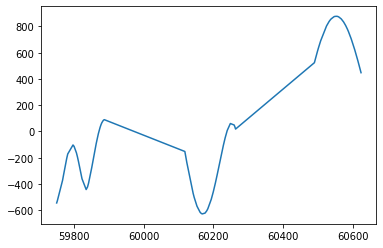

Iter 0085 | Total Loss 525.904297


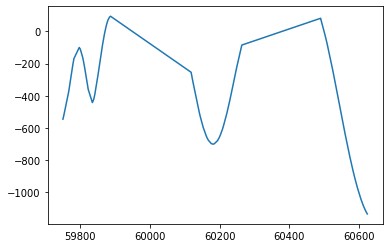

Iter 0090 | Total Loss 660.925354


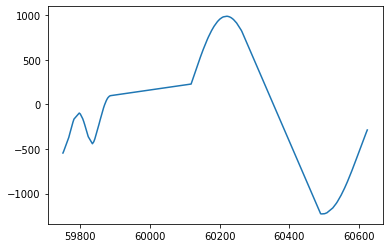

Iter 0095 | Total Loss 671.554443


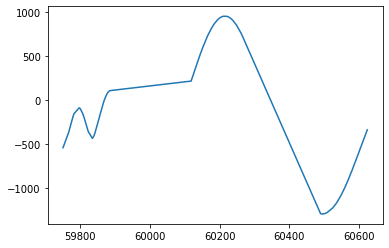

Iter 0100 | Total Loss 689.189819


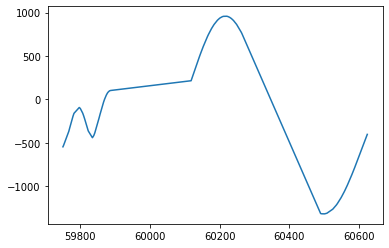

Iter 0005 | Total Loss 559.907288


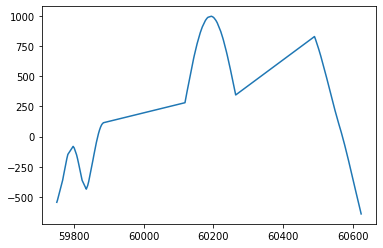

Iter 0010 | Total Loss 558.937561


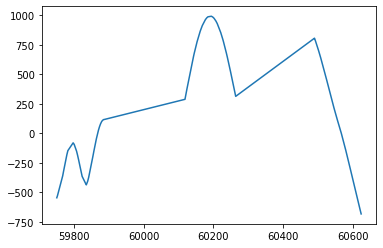

Iter 0015 | Total Loss 557.999146


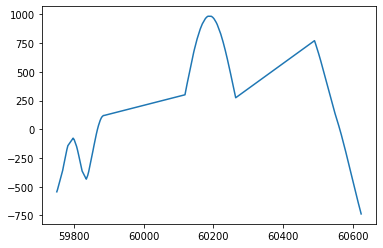

Iter 0020 | Total Loss 561.622864


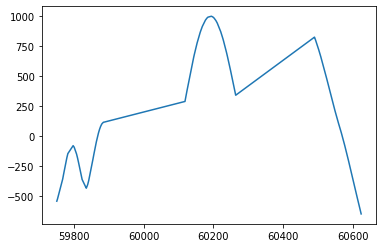

Iter 0025 | Total Loss 559.389038


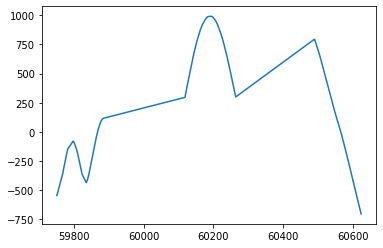

Iter 0030 | Total Loss 561.515564


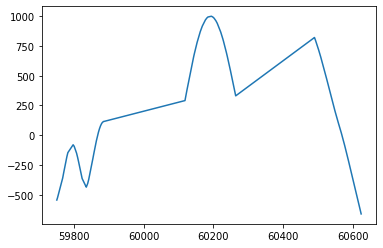

Iter 0035 | Total Loss 566.937622


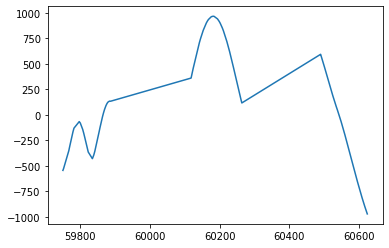

Iter 0040 | Total Loss 599.016846


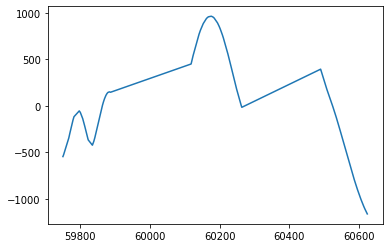

Iter 0045 | Total Loss 617.063293


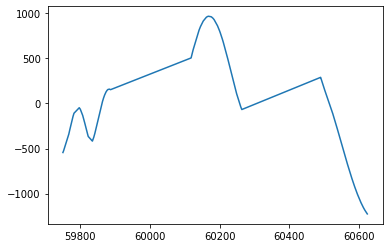

Iter 0050 | Total Loss 637.603271


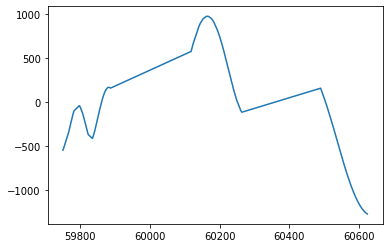

Iter 0055 | Total Loss 655.650208


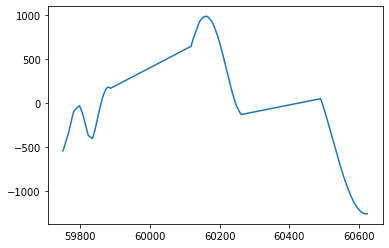

Iter 0060 | Total Loss 666.643555


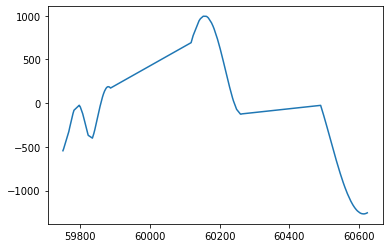

Iter 0065 | Total Loss 666.848328


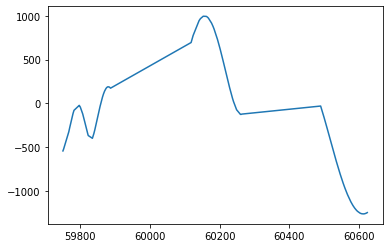

Iter 0070 | Total Loss 662.035095


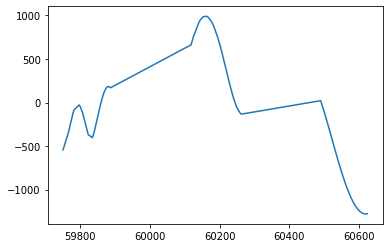

Iter 0075 | Total Loss 666.465576


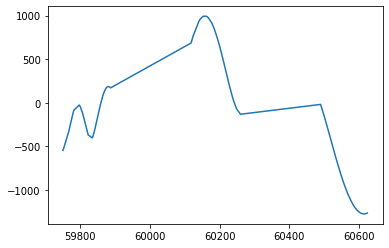

Iter 0080 | Total Loss 674.955078


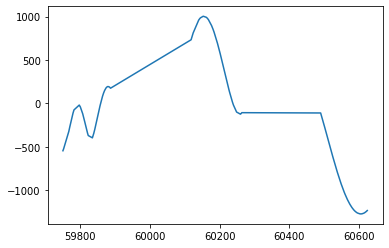

Iter 0085 | Total Loss 684.192261


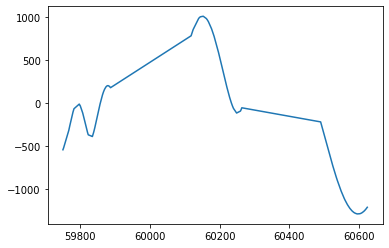

Iter 0090 | Total Loss 689.071899


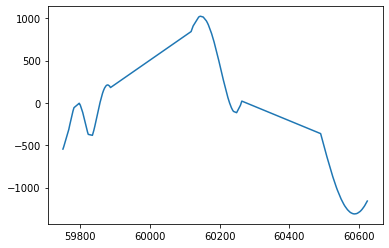

Iter 0095 | Total Loss 692.616821


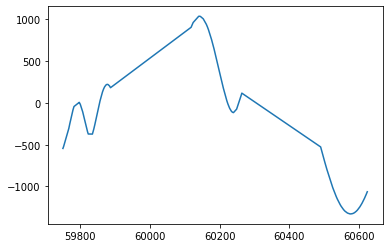

Iter 0100 | Total Loss 692.405334


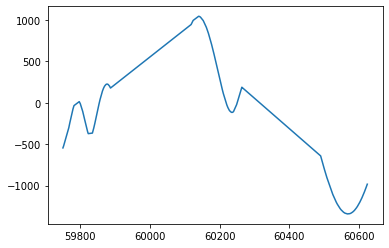

In [149]:
for epoch in range(1, epochs+1):    
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        by0_f, bt_f, by_f = ode_batch(times, fluxes)
        pred_f = odeint(odefunc, by0_f, bt_f, rtol=.5, atol=.2)
        loss = torch.mean(torch.abs(pred_f - by_f))
        loss.backward()
        optimizer.step()
#         print(itr)
        if itr % test_freq == 0:
            with torch.no_grad():
#                 clear_output()
                pred_f = odeint(odefunc, flux_y0, mjds, rtol=.5, atol=.2)
                loss = torch.mean(torch.abs(pred_f - true_f))
                losses.append(loss)
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                plt.plot(mjds.tolist(), pred_f.flatten().tolist())
                plt.show()
                ii += 1    

In [145]:
print(losses)

[tensor(2388.5100), tensor(17364.4238), tensor(12932.0977), tensor(13151.8066), tensor(11326.7754), tensor(14904.3848), tensor(18594.4141), tensor(19549.4512), tensor(18051.7363), tensor(18634.8320), tensor(13680.6396), tensor(14939.2227), tensor(29904.5391), tensor(13781.5869), tensor(18677.6953), tensor(32532.2930), tensor(44748.0273), tensor(50418.4961), tensor(52898.1367), tensor(55383.4531), tensor(57819.5859), tensor(60172.8125), tensor(62395.1641), tensor(64125.8984), tensor(65514.5000), tensor(36138.8086), tensor(46123.2422), tensor(36798.3711)]


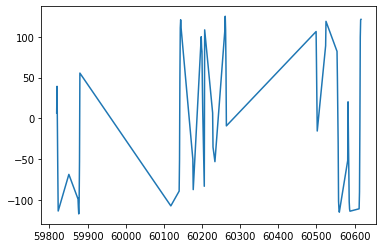

In [147]:
plt.plot(times.numpy(), flux_list.numpy())

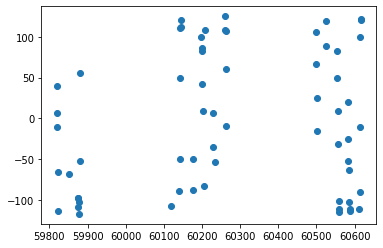

In [150]:
plt.scatter(times.numpy(), flux_list.numpy())
plt.show()